# Project Overview
#### The CIFAR-10 dataset consists of 60,000 images categorized into 10 distinct classes, making it a cornerstone resource for image recognition endeavors. Divided into 50,000 images for training and 10,000 for testing, each image is meticulously labeled under one of ten categories, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck. These images are converted into NumPy arrays, stored as 'train_images.npy' and 'test_images.npy', while the corresponding labels are saved as 'train_labels.csv'. This format facilitates seamless integration with machine learning models, offering a robust foundation for training and evaluation purposes. Applications of this dataset range from intuitive image search functionalities in mobile photo albums to the detection of non-human activity in sensitive web form submissions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential,Model, load_model
from keras import losses
from keras import initializers
from keras.layers import Activation ,Dropout ,Flatten,Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import os

# Importing Dataset
## Dataset Link : https://www.cs.toronto.edu/~kriz/cifar.html
#### Loaded in this way, each of the batch files contains a dictionary with the following elements:
#### data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
#### labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [ ]:
print(os.listdir("/content/drive/MyDrive/Object Detection/Cifar-10"))

['test_images.npy', 'train_labels.csv', 'train_images.npy']


In [ ]:
csv_train = pd.read_csv('/content/drive/MyDrive/Object Detection/Cifar-10/train_labels.csv')
labels = pd.Series(csv_train['Category'])

csv_train.head(10)

,Id,Category
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


# Processing the data for train-test-split

In [ ]:
x_train = np.load('/content/drive/MyDrive/Object Detection/Cifar-10/train_images.npy')
x_test = np.load('/content/drive/MyDrive/Object Detection/Cifar-10/test_images.npy')

print(x_train.shape)
print(x_test.shape)

(50000, 3, 32, 32)
(200000, 3, 32, 32)


In [ ]:
lb= LabelBinarizer()
y_train = labels
y_train=lb.fit_transform(y_train)

x_train = x_train /255
x_test = x_test/255
classes = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]
print('labels',y_train.shape)
print("classes: ", classes)

labels (50000, 10)
classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
X_train.shape

(40000, 3, 32, 32)

In [ ]:
Y_train.shape

(40000, 10)

In [ ]:
print("Training data set size: ", X_train.shape, Y_train.shape, "\n")
for a in range (10):
    print(X_train[a].shape, Y_train[a])

Training data set size:  (40000, 3, 32, 32) (40000, 10) 

(3, 32, 32) [0 0 0 1 0 0 0 0 0 0]
(3, 32, 32) [0 0 1 0 0 0 0 0 0 0]
(3, 32, 32) [0 1 0 0 0 0 0 0 0 0]
(3, 32, 32) [0 0 0 0 0 0 1 0 0 0]
(3, 32, 32) [0 0 0 0 0 0 0 1 0 0]
(3, 32, 32) [0 0 0 0 0 0 0 1 0 0]
(3, 32, 32) [0 0 0 1 0 0 0 0 0 0]
(3, 32, 32) [0 0 0 0 0 0 0 0 1 0]
(3, 32, 32) [0 0 0 0 0 1 0 0 0 0]
(3, 32, 32) [1 0 0 0 0 0 0 0 0 0]


# Model Creation

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

np.random.seed(0)
weight_decay = 0.0001

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', data_format="channels_first", input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3,3), padding='same', data_format="channels_first", kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), padding='same', data_format="channels_first", kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3, 3), padding='same', data_format="channels_first", kernel_initializer='TruncatedNormal', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.7))

    model.add(Flatten())

    model.add(Dense(num_classes, activation='softmax'))

    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()
    return model


In [ ]:
batch_size = 128
num_classes = 10
epochs =150

model =create_model()

cnn=model.fit(X_train, Y_train, batch_size=batch_size,epochs=epochs, validation_data=(X_valid,Y_valid),shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 32, 32)        18496     
                                                                 
 activation_9 (Activation)   (None, 64, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 16, 32)       36992     
                                                      

In [ ]:
max_train_accuracy = max(cnn.history['accuracy'])
max_val_accuracy = max(cnn.history['val_accuracy'])

print("Training Accuracy:", max_train_accuracy)
print("Validation Accuracy:", max_val_accuracy)

Training Accuracy: 0.9207500219345093
Validation Accuracy: 0.8141000270843506


In [ ]:
y_pred_probs = model.predict(X_valid)
y_pred = np.argmax(y_pred_probs, axis=1)

y_valid_int = np.argmax(Y_valid, axis=1)

accuracy = accuracy_score(y_valid_int, y_pred)

precision = precision_score(y_valid_int, y_pred, average='weighted')

recall = recall_score(y_valid_int, y_pred, average='weighted')

f1 = f1_score(y_valid_int, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

313/313 [==============================] - 2s 4ms/step
Accuracy: 0.8104
Precision: 0.8117696124185578
Recall: 0.8104
F1 Score: 0.8087718627791437


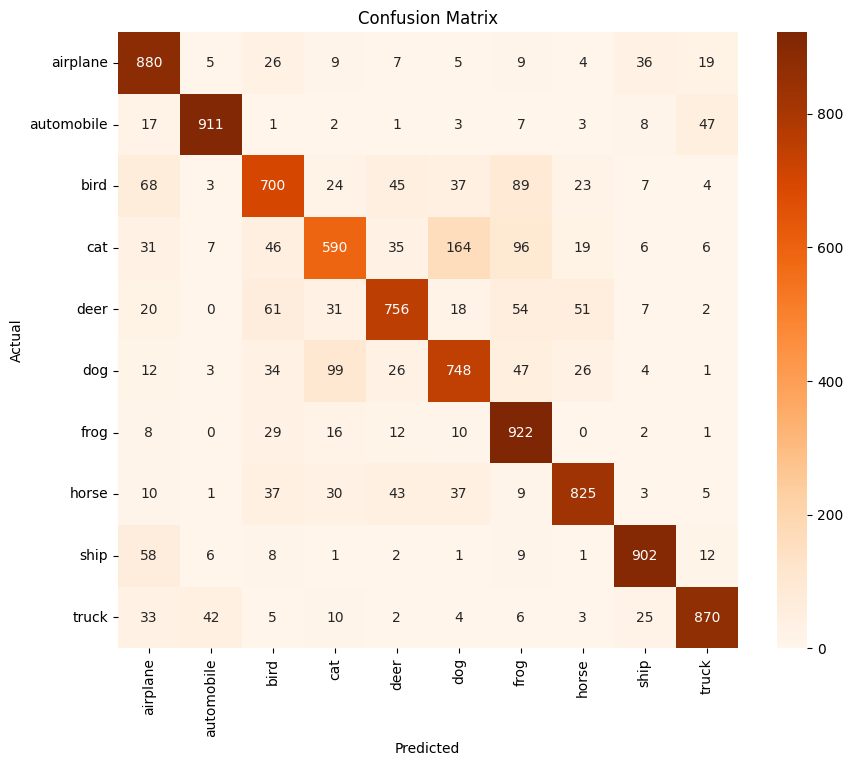

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


conf_matrix = confusion_matrix(y_valid_int, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# max_train_accuracy = max(cnn.history['accuracy'])
# max_val_accuracy = max(cnn.history['val_accuracy'])

# print("Highest Training Accuracy:", max_train_accuracy)
# print("Highest Validation Accuracy:", max_val_accuracy)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


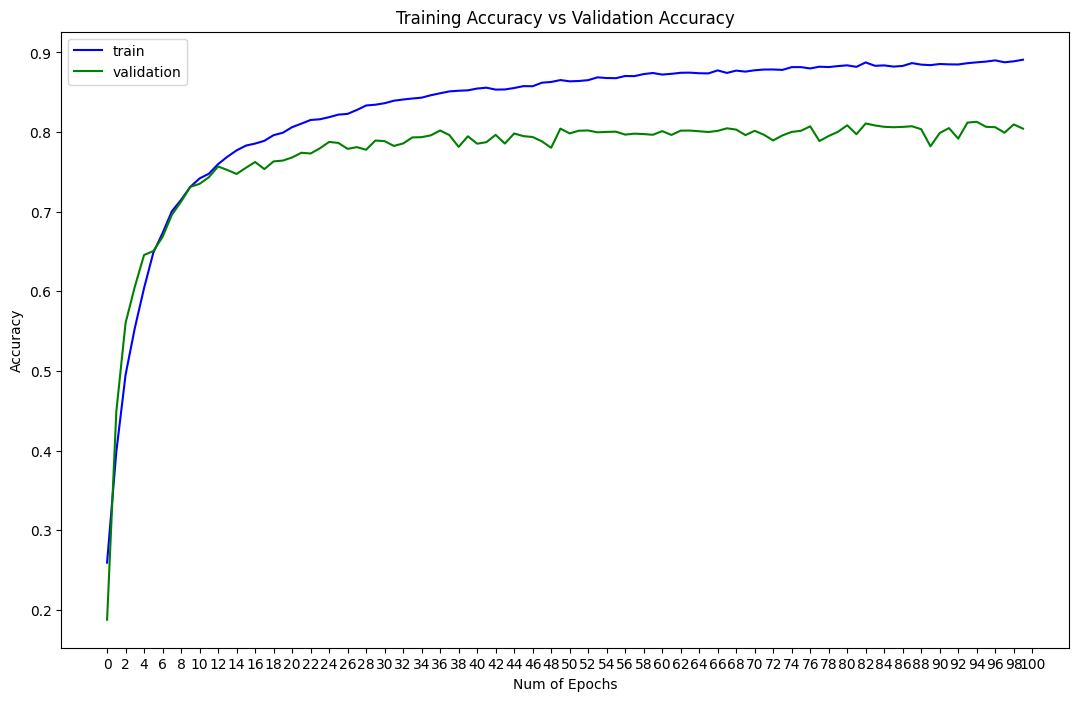

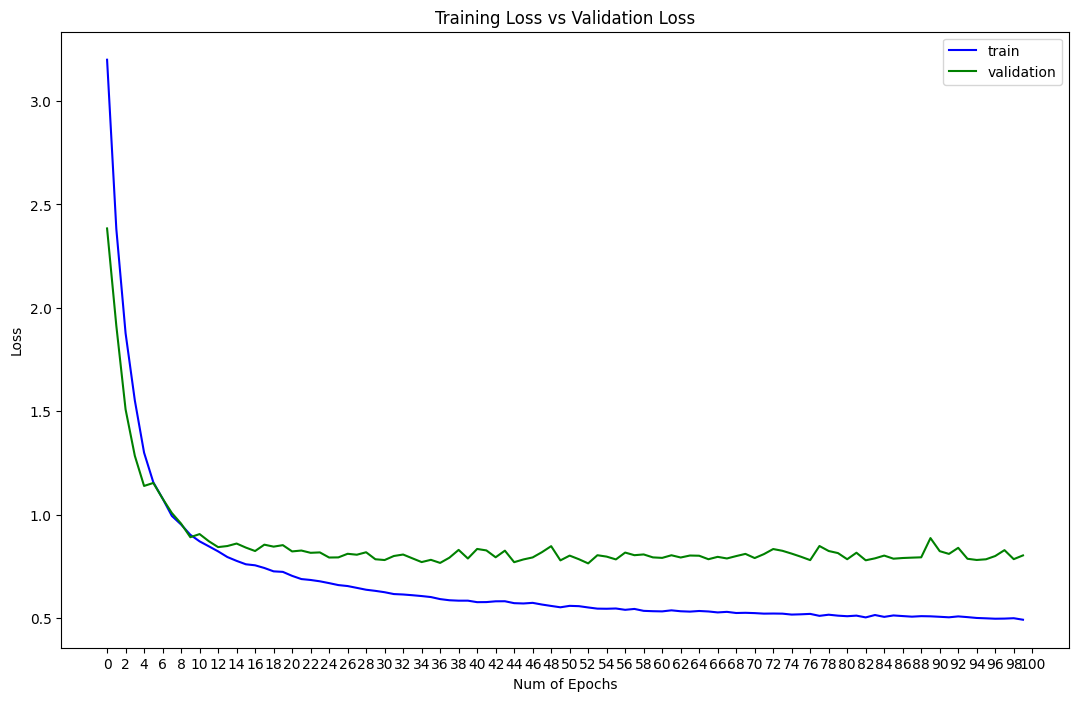

In [ ]:
print(cnn.history.keys())

plt.figure(0)
plt.plot(cnn.history['accuracy'],'b')
plt.plot(cnn.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (13, 8)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'b')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (13, 8)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()


# Prediction

In [ ]:
# Predict Against Training Data
index = 0
prediction = model.predict(x_train[:20], verbose=1)
for p in prediction:
    print("Actual class:", y_train[index])
    rounded_prediction = [round(prob, 3) for prob in p]
    print("Predicted class:", rounded_prediction, "\n")
    index += 1


1/1 [==============================] - 0s 392ms/step
Actual class: [0 0 0 0 0 0 1 0 0 0]
Predicted class: [0.0, 0.0, 0.001, 0.011, 0.0, 0.0, 0.987, 0.0, 0.0, 0.0] 

Actual class: [0 0 0 0 0 0 0 0 0 1]
Predicted class: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 

Actual class: [0 0 0 0 0 0 0 0 0 1]
Predicted class: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 

Actual class: [0 0 0 0 1 0 0 0 0 0]
Predicted class: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: [0 1 0 0 0 0 0 0 0 0]
Predicted class: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: [0 1 0 0 0 0 0 0 0 0]
Predicted class: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: [0 0 1 0 0 0 0 0 0 0]
Predicted class: [0.001, 0.0, 0.994, 0.0, 0.004, 0.0, 0.0, 0.001, 0.0, 0.0] 

Actual class: [0 0 0 0 0 0 0 1 0 0]
Predicted class: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] 

Actual class: [0 0 0 0 0 0 0 0 1 0]
Predicted class: [0.003, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
index = 0
prediction = model.predict(x_train[:30], verbose=1)
for p in prediction:
    actual_class = classes[np.argmax(y_train[index])]
    print("Actual class:", actual_class)

    rounded_prediction = [round(prob, 3) for prob in p]
    predicted_class = classes[np.argmax(p)]
    print("Predicted class:", predicted_class, "with probabilities:", rounded_prediction, "\n")

    index += 1


1/1 [==============================] - 0s 330ms/step
Actual class: frog
Predicted class: frog with probabilities: [0.0, 0.0, 0.001, 0.011, 0.0, 0.0, 0.987, 0.0, 0.0, 0.0] 

Actual class: truck
Predicted class: truck with probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 

Actual class: truck
Predicted class: truck with probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0] 

Actual class: deer
Predicted class: deer with probabilities: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: automobile
Predicted class: automobile with probabilities: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: automobile
Predicted class: automobile with probabilities: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 

Actual class: bird
Predicted class: bird with probabilities: [0.001, 0.0, 0.994, 0.0, 0.004, 0.0, 0.0, 0.001, 0.0, 0.0] 

Actual class: horse
Predicted class: horse with probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0